In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 
import os

In [2]:
# Unzip data.zip if it hasn't been done yet. Expects data.zip on the same level as this notebook.
if not os.path.isdir('data'):
    print("Unzipping data")
    os.makedirs('data')
    import zipfile
    with zipfile.ZipFile("data.zip", 'r') as zip_ref:
        zip_ref.extractall("data")

In [3]:
# Read data from files
df_data = pd.read_parquet('data/data.parquet', engine='fastparquet')
df_labels = pd.read_csv('data/labels.csv')

# Quick view of what the data looks like
print(df_data.info(), "\n")
print(df_data.describe(), "\n")
print(df_data.tail(n=10), "\n")

# Quick view of what the labels looks like
print(df_labels.info(), "\n")
print(df_labels.describe(), "\n")
print(df_labels.tail(n=10), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB
None 

       MeasurementId      Pressure
count   1.846636e+07  1.846636e+07
mean    3.398397e+03  3.338926e-01
std     3.019365e+03  4.862787e-01
min    -1.000000e+00  0.000000e+00
25%    -1.000000e+00  0.000000e+00
50%     3.179000e+03  0.000000e+00
75%     6.277000e+03  7.017707e-01
max     8.834000e+03  6.774464e+00 

         MachineId  MeasurementId  Pressure
18466354    10_0_3           8834       0.0
18466355    10_0_3           8834       0.0
18466356    10_0_3           8834       0.0
18466357    10_0_3           8834       0.0
18466358    10_0_3           8834       0.0
18466359    10_0_3           8834       0.0
18466360    10_0_3           8834       0.0
184663

In [4]:
# === Print some information to examine data ===
print("N data points: ", len(df_data), "\n")

# Amount of machines
n_unique_machines = df_data.MachineId.nunique()
print("Num of unique machine Ids: ", n_unique_machines, "\n")

# Amount of unique machine-cycle combos
n_unique_cycles = df_data.groupby(['MachineId', 'MeasurementId']).ngroups
print("Num of unique cycles: ", n_unique_cycles, "\n")

# Stats of cycles that each machine goes through (we can maybe use to examine fault trends)
machine_cyc_df = df_data.groupby("MachineId")["MeasurementId"].unique()
cycles_per_machine = machine_cyc_df.apply(lambda x: len(x))
print("Cycles per machine stats: ", "\n")
print(cycles_per_machine.describe(), "\n")

N = 50
print(f"Num of machines with more than {N} cycles: ", len(cycles_per_machine[cycles_per_machine > N]), "\n")

# Statistics of amount of measurements per cycle
count_df = df_data.groupby(['MachineId', 'MeasurementId'])["Pressure"].count()
print("Stats of amount of measurements per cycle", "\n")
print(count_df.describe(), "\n")

# Number of cycles that are too long
print("Amount of cycles that are too long", len(count_df[count_df > 10000]), "\n")

# Some wierd cycle with negative ID and too many values (edit: nans)
print("Entry with too many cycles: ", count_df[count_df > 10000], "\n")

N data points:  18466364 

Num of unique machine Ids:  556 

Num of unique cycles:  27385 

Cycles per machine stats:  

count    556.000000
mean      49.253597
std      134.393005
min        1.000000
25%        1.000000
50%        2.000000
75%       20.000000
max      970.000000
Name: MeasurementId, dtype: float64 

Num of machines with more than 50 cycles:  100 

Stats of amount of measurements per cycle 

count     27385.000000
mean        674.324046
std        3651.210385
min          93.000000
25%         354.000000
50%         438.000000
75%         579.000000
max      185476.000000
Name: Pressure, dtype: float64 

Amount of cycles that are too long 99 

Entry with too many cycles:  MachineId  MeasurementId
0_0_0      -1               101711
0_0_1      -1                90267
0_0_2      -1                82389
0_0_3      -1                68346
0_1_0      -1               116338
                             ...  
9_4_0      -1                11728
9_4_2      -1                102

In [5]:
# === Print information on loaded labels ===
print("N labels: ", len(df_labels), "\n")

# Amount of machines to check if same in data
n_unique_machines = df_labels.MachineId.nunique()
print("Num of unique machine Ids: ", n_unique_machines, "\n")

# Amount of unique cycles to check if same in data
n_unique_cycles = df_labels.MeasurementId.nunique()
print("Num of unique cycles: ", n_unique_cycles, "\n")

# Check for nans
print("Labels nan values: ", "\n")
print(df_labels.isna().sum(), "\n")

# Get all ids where pump failure label is nan
nan_ids_df = df_labels[df_labels["PumpFailed"].isna()][["MachineId", "MeasurementId"]]
print(nan_ids_df, "\n")

# Comment: It looks like measurementId of -1 coincides with a nan at pumpfailure. 

# Check label balance
print("Label ratios: ", "\n")
print(df_labels[["PumpFailed", "SlowStart", "SlowEnd"]].apply(pd.Series.value_counts, normalize=True, dropna=True), "\n")
# Comment: An unexpectedly high amount of cycles with pump failures. 

# Check how slowstarts and ends correlate with pump failure
df_labels_cp = df_labels.copy()
df_labels_cp = df_labels_cp.astype({"PumpFailed": np.float32, "SlowStart": np.float32, "SlowEnd": np.float32}, errors='raise') 
df_labels_cp[["PumpFailed", "SlowStart", "SlowEnd"]].corr()

# Comment: Nothing too significant in label correlation matrix, SlowEnd correlates negatively with pumpfailed.

N labels:  27385 

Num of unique machine Ids:  556 

Num of unique cycles:  8836 

Labels nan values:  

MachineId           0
MeasurementId       0
PumpFailed        485
SlowStart        8085
SlowEnd          8085
dtype: int64 

      MachineId  MeasurementId
1         0_0_1             -1
4         0_1_0             -1
6         0_1_2             -1
7         0_1_3             -1
9         1_0_1             -1
...         ...            ...
25788    15_0_2             -1
25789    15_0_3             -1
25792    15_0_1             -1
27018    11_2_2             -1
27019    11_2_3             -1

[485 rows x 2 columns] 

Label ratios:  

       PumpFailed  SlowStart   SlowEnd
False    0.890632   0.945544  0.801917
True     0.109368   0.054456  0.198083 



,PumpFailed,SlowStart,SlowEnd
PumpFailed,1.000000,-0.085193,-0.175608
SlowStart,-0.085193,1.000000,-0.118700
SlowEnd,-0.175608,-0.118700,1.000000


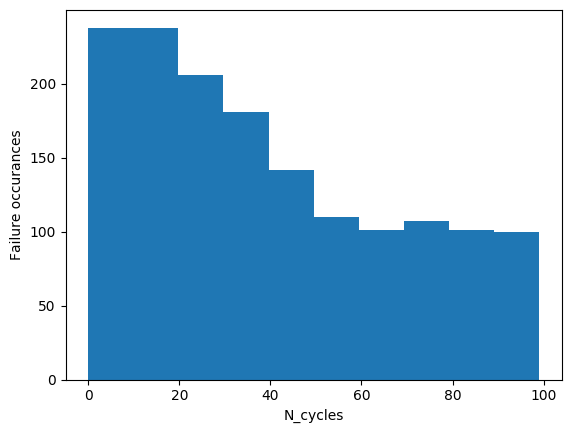

In [6]:
# Comment: We assume the machines are not related to one another.

# Comment: It looks like failure doesn't mean a permanent failure and the machine is continued to be used, which is strange.
#print(df_data[df_data["MachineId"]=="1_0_1"])
#print(df_labels[df_labels["MachineId"]=="1_0_1"])

# Comment: We can examine whether failure is more likely after a machine has gone through a
# specific amount of cycle (or maybe follows a bathtub curve). We will only use machine that have gone 
# through at least N cycles to avoid normalizing, as well as other potential issues 
# (some machines only have a few cycles).

# Get series of machines and list of cycles (measurements)
machines_ser = df_data.groupby("MachineId")["MeasurementId"].unique()

N = 100

# Get machine ID list
failures_indeces_list = []
for mach_id, meas_ids in zip(machines_ser.index, machines_ser.values):
    if len(meas_ids) > N:
        # get labels for all cycles
        indeces = df_labels.loc[df_labels["MachineId"]==mach_id, "PumpFailed"].values
        
        # Only use first N indeces to avoid false results above this number.
        filt_indeces = indeces[:N]
        
        # find indeces of failures
        failure_indeces = np.where(filt_indeces==True)[0]

        # Append failure index
        for fi in failure_indeces:
            failures_indeces_list.append(fi)
            
# Histogram the failed indeces
_ = plt.hist(failures_indeces_list, bins=10)
_ = plt.xlabel("N_cycles")
_ = plt.ylabel("Failure occurances")

# Comment: We can see that failures happen almost twice as frequently in the initial cycles than later on,
# but we don't have enough long cycles to see if the failure rate rises later on.
# We can use this info as a feature or additional threshold value for the model decision. 

In [7]:
# ======== Plot several normal pressure cycles, failed cycles, slowstart and slowend cycles ============
def plot_cycles(cycles, title):
    plt.figure()
    plt.title(title)
    plt.ylabel("Pressure [KPa]")
    plt.xlabel("Time")
    for mach_id, meas_id in zip(cycles["MachineId"], cycles["MeasurementId"]):
        # Get pressure data for specific cycle
        cyc = df_data.loc[(df_data["MachineId"]==mach_id) & (df_data["MeasurementId"]==meas_id), "Pressure"].values
        plt.plot(cyc)

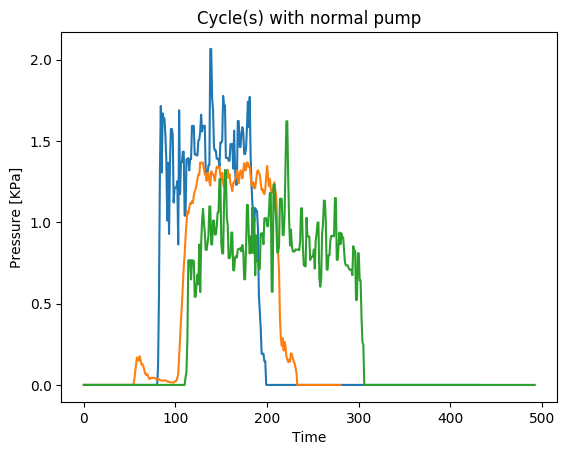

In [8]:
# ====== Cycles with normal pump

# Randomly selected cycles with pump failure
df_no_pump_failure = df_labels.loc[df_labels["PumpFailed"]==False ,["MachineId", "MeasurementId"]].sample(n=3)

# Plot selection
plot_cycles(df_no_pump_failure, "Cycle(s) with normal pump")

# Comment: Normal operation feature various operating pressure levels
# Comment: Sometimes pressure values are zero through the whole (normal) cycle, sometimes other strange spikes (bad measurement or label?)
# Comment: Normal cycle is usually sharp up and sharp down, with high frequency noise, but without ups and downs.


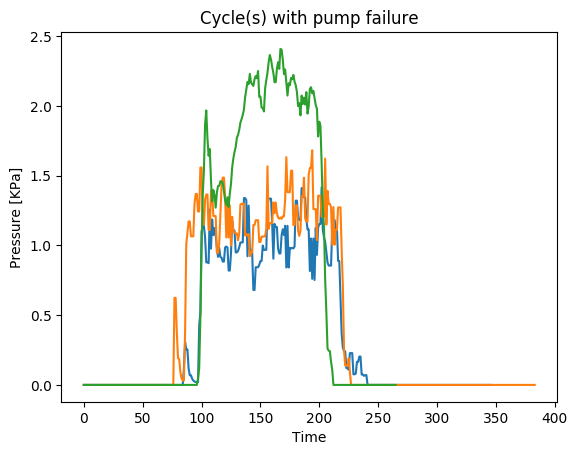

In [9]:
# ====== Cycles with pump failure

# Randomly selected cycles with pump failure
df_with_pump_failure = df_labels.loc[df_labels["PumpFailed"]==True ,["MachineId", "MeasurementId"]].sample(n=3)

# Plot selection
plot_cycles(df_with_pump_failure, "Cycle(s) with pump failure")

# Comment: Relatively consistent failure feature is a dip in pressure after initial pressure rise, otherwise normal pressure levels are usually reached.
# The dip in pressure spans roughly 50 time units

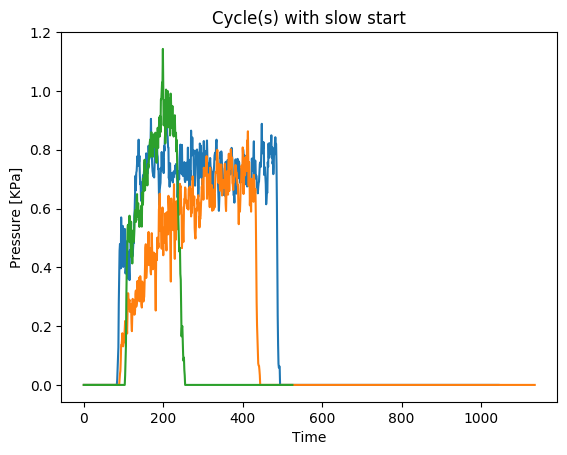

In [10]:
# ====== Cycles with slow start

# Randomly selected cycles with pump failure
df_slow_start = df_labels.loc[df_labels["SlowStart"]==True ,["MachineId", "MeasurementId"]].sample(n=3)

# Plot selection
plot_cycles(df_slow_start, "Cycle(s) with slow start")

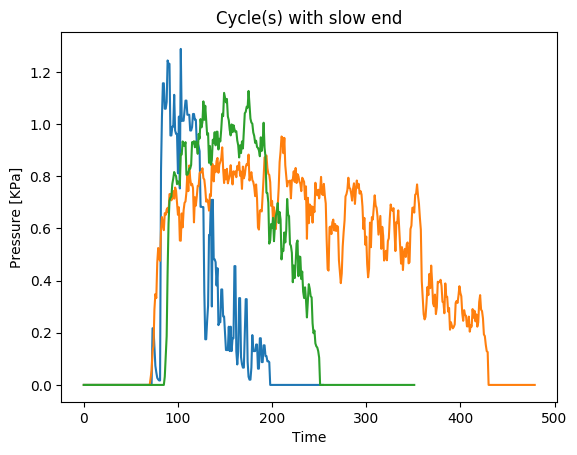

In [11]:
# ====== Cycles with slow end

# Randomly selected cycles with pump failure
df_slow_end = df_labels.loc[df_labels["SlowEnd"]==True ,["MachineId", "MeasurementId"]].sample(n=3)

# Plot selection
plot_cycles(df_slow_end, "Cycle(s) with slow end")

In [12]:
# === Merge the data and labels dataframes === 

# Group the pressure measurements in each cycle into a list
df_data_gr = df_data.groupby(["MachineId", "MeasurementId"])["Pressure"].apply(list).reset_index()

# Merge on matching columns (MachineId and MeasurementId)
df_comb = pd.merge(df_data_gr, df_labels)

# Remove rows with nan pressure or pumpfailed data
df_comb = df_comb.dropna(subset=["Pressure", "PumpFailed"], axis=0)

print(df_comb.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26900 entries, 1 to 27384
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      26900 non-null  object
 1   MeasurementId  26900 non-null  int64 
 2   Pressure       26900 non-null  object
 3   PumpFailed     26900 non-null  object
 4   SlowStart      19300 non-null  object
 5   SlowEnd        19300 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.4+ MB
None


[9, 13, 19, 9, 15, 16, 19, 16, 14, 2, 20, 15, 14, 15, 4, 2, 15, 7, 17, 7, 11, 20, 4, 5, 1, 2, 9, 11, 17, 20, 7, 20, 8, 17, 2, 2, 3, 3, 10, 2, 4] 

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False] 

Shortest seq:  0 Longest seq:  1192 N short seqs:  41 N norm seqs:  26859 

(26859, 600) (26859,)


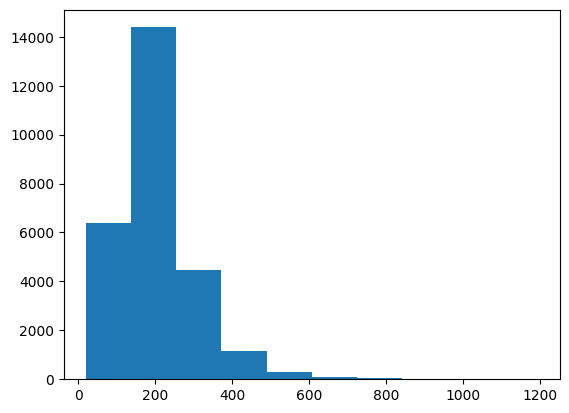

In [13]:
# == Get data into X, Y ndarray form, clean, trim, pad, and normalize (maybe)

# List of lists of pressure measurements  
X = df_comb["Pressure"].values

# TODO: Get machine cycle number feature and cycle length feature to add to pressure list 

# Get labels
Y = df_comb["PumpFailed"].values

# Make small subsequence for fast testing (comment this line later)
#X_list = X_list[0:50]

# Trim each sequence to get just the cycle information
thresh = 0.05
X_trimmed = []
Y_trimmed = []
X_short = []
Y_short = []
shortest_seq = 0
longest_seq = 0
for x, y in zip(X, Y):
    # First occurance of val above thresh
    init_idx = np.argmax(np.array(x) > thresh)
    
    # Last occurance of val above thresh
    last_idx = len(x) - np.argmax(np.array(list(reversed(x))) > thresh)
    
    # Make sure no anomalous sequence gets in
    seq_len = last_idx - init_idx 
    
    # Exclude very short sequences
    if seq_len > 20:
        X_trimmed.append(x[init_idx:last_idx])
        Y_trimmed.append(y)
    else:
        # Append whole cycle for plot
        X_short.append(x[init_idx:last_idx])
        Y_short.append(y)
    
    shortest_seq = seq_len if seq_len < shortest_seq else shortest_seq
    longest_seq = seq_len if seq_len > longest_seq else longest_seq
    
# Short sequence lengths
print([len(x) for x in X_short], "\n")
# Comment: Some sequences are way too short in comparison with the nominal length for any meaningful classification.

# Short sequence labels
print(Y_short, "\n")
# Comment: All strangely short sequences have negative pump failure label.
# It's probably better to classify all short sequences as non-failures..
    
print("Shortest seq: ", shortest_seq, "Longest seq: ", longest_seq, "N short seqs: ", len(X_short), "N norm seqs: ", len(X_trimmed), "\n")

# Plot some of the very short cycles to see what is going on there
# for i in range(1):
#    cyc = X_short[np.random.randint(0, len(X_short))]
#    plt.plot(np.arange(len(cyc)), cyc)

# for i in range(3):
#    cyc = X_trimmed[np.random.randint(0, len(X_trimmed))]
#    plt.plot(np.arange(len(cyc)), cyc)

# Histogram of cycle lengths
_ = plt.hist([len(x) for x in X_trimmed])

# Based on above histogram, we will cut all sequences and pad to max_time_units 
max_time_units = 600
X_padded = []
for x in X_trimmed:
    if len(x) > max_time_units:
        X_padded.append(x[:max_time_units])
    else:
        X_padded.append(x + [0] * (max_time_units - len(x)))
        
    assert len(X_padded[-1]) == max_time_units

# Prepared array data for training
X = np.array(X_padded, dtype=np.float32)
Y = np.array(Y_trimmed, dtype=np.int_)

print(X.shape, Y.shape)

In [14]:
# == Assume that we want to predict pump failure after the cycle completes. 
# Fit baseline model on raw padded pressure data for baseline. Treat sequence as static example. ==

import sklearn.metrics
import sklearn.datasets
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

N_data = len(X) # Use subset of data if necessary
seqlen = 600 # limit sequence length if necessary (MAX 600)
skip = 1 # Every data point is probably not necessary, we can skip every nth

# Split into training and test data
X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(X[:N_data, 0:seqlen:skip], Y[:N_data], random_state=1337, train_size=0.9)

In [15]:
# Function for evaluating the classifier (F1 score, confusion matrix, prec-recall curve).
def evaluate_classif(clf, X_train, y_train, X_test, y_test, model_name):
    y_hat = clf.predict(X_train)
    print("F1 score on trn", sklearn.metrics.f1_score(y_train, y_hat))

    y_hat_tst = clf.predict(X_test)
    print("F1 score on tst", sklearn.metrics.f1_score(y_test, y_hat_tst))

    display_cm = sklearn.metrics.ConfusionMatrixDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            display_labels=["normal", "failed"],
            cmap=plt.cm.Blues,
        )

    _ = display_cm.ax_.set_title("2-class Confusion matrix")

    display_pr = sklearn.metrics.PrecisionRecallDisplay.from_estimator(
        clf, X_test, y_test, name=model_name
    )
    _ = display_pr.ax_.set_title("2-class Precision-Recall curve")

/home/silverjoda/SW/ml_ops/coding_challenges/pumpfailure_det/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


F1 score on trn 0.8684603886397608
F1 score on tst 0.6835016835016835


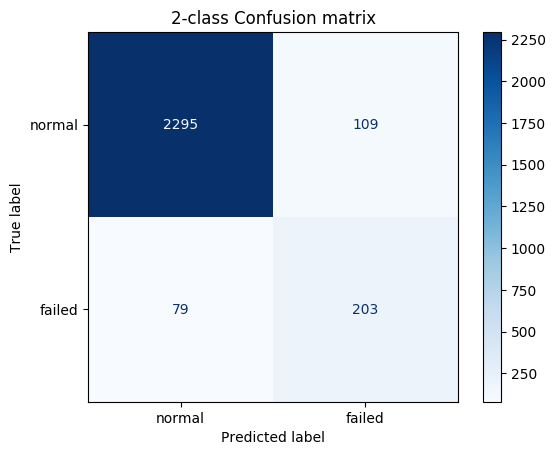

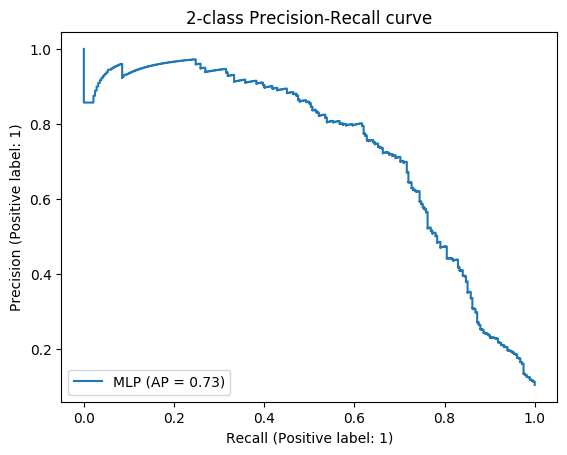

In [16]:
# Train the sequence as a single example (Warning: don't use GP with the entire dataset, it will likely try to allocate too much memory)
model_name = "MLP"
clf_dict = {"MLP" : MLPClassifier(),
            "GP" : GaussianProcessClassifier(copy_X_train=False)}

clf = make_pipeline(clf_dict[model_name]) # StandardScaler(), 
clf.fit(X_train, y_train)

evaluate_classif(clf, X_train, y_train, X_test, y_test, model_name)

/home/silverjoda/SW/ml_ops/coding_challenges/pumpfailure_det/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3612       0.8900        0.3466  1.1743
      2        0.3462       0.8900        0.3455  0.9898
      3        0.3385       0.8900        0.3229  1.0419
      4        0.2618       0.9173        0.2330  1.0748
      5        0.2119       0.9355        0.2028  1.0613
      6        0.1887       0.9444        0.1715  1.0868
      7        0.1784       0.9384        0.1951  1.1371
      8        0.1705       0.9483        0.1645  1.0886
      9        0.1674       0.9442        0.1720  0.9850
     10        0.1631       0.9487        0.1588  0.7264
     11        0.1628       0.9456        0.1788  0.7226
     12        0.1612       0.9464        0.1662  0.7203
     13        0.1572       0.9489        0.1580  0.7479
     14        0.1599       0.9481        0.1761  0.7924
     15        0.1588       0.9506        0.1601  0.9276
     16        0.1542       0.9

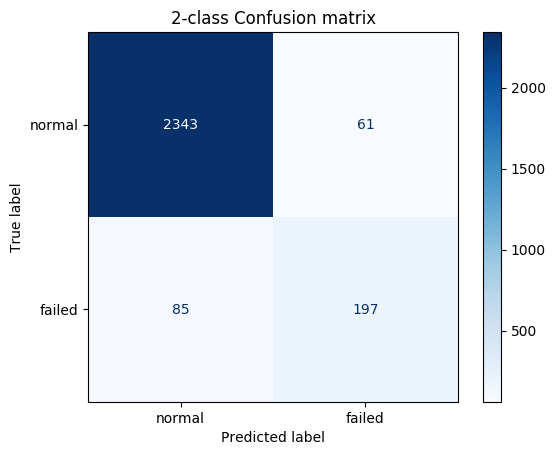

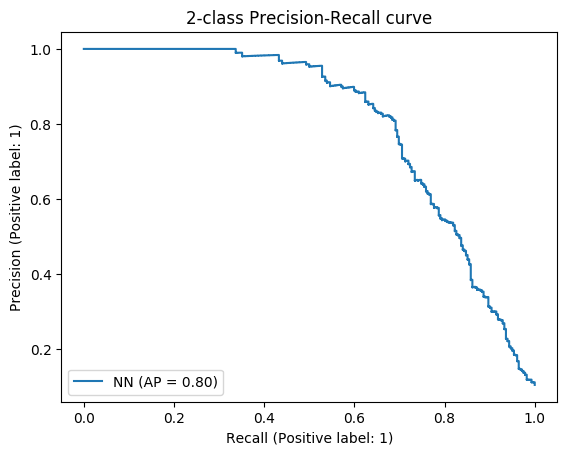

In [17]:
# == Nuclear option: Use RNN or convolutions to classify sequence. ==
import torch as T
from torch import nn
from skorch import NeuralNetClassifier
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, obs_dim=1, act_dim=2, hid_dim=16):
        super(RNN, self).__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.hid_dim = hid_dim
        num_layers = 1 

        self.rnn_1 = T.nn.LSTM(input_size=self.obs_dim, hidden_size=self.hid_dim, num_layers=num_layers, batch_first=True)
        self.fc2 = T.nn.Linear(self.hid_dim, self.act_dim, bias=True)

    def forward(self, x):
        x_rs = x.unsqueeze(2)
        rnn_1, _ = self.rnn_1(x_rs, None)
        rnn_last = rnn_1[:, -1, :]
        fc2 = self.fc2(rnn_last)
        out = F.softmax(fc2, dim=-1)
        return out
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv1d(
                in_channels=1,            
                out_channels=16,         
                kernel_size=5,              
                stride=2,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool1d(kernel_size=2),  
        )
        self.conv2 = nn.Sequential(         
            nn.Conv1d(
                in_channels=16,             
                out_channels=8,             
                kernel_size=5,              
                stride=2,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool1d(kernel_size=2),    
            
        )
        self.conv3 = nn.Sequential(         
            nn.Conv1d(
                in_channels=8,             
                out_channels=8,             
                kernel_size=3,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool1d(kernel_size=2),    
            
        )
        self.conv4 = nn.Sequential(         
            nn.Conv1d(
                in_channels=8,             
                out_channels=8,             
                kernel_size=3,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool1d(kernel_size=2),    
        )
        self.out = nn.Linear(8 * 7, 2) 
        
    def forward(self,x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.reshape((-1, 8 * 7))
        output = F.softmax(self.out(x), dim=-1)
        return output
    
# CNN works (F=0.73, AP=0.8), RNN has some issue, doesn't train.
clf = NeuralNetClassifier(
    CNN,
    max_epochs=30,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=T.optim.Adam
)

# Train and evaluate model
model_name = "NN"
clf.fit(X_train, y_train) 
evaluate_classif(clf, X_train, y_train, X_test, y_test, model_name)

F1 score on trn 0.7539764511464573
F1 score on tst 0.6115384615384616


/home/silverjoda/SW/ml_ops/coding_challenges/pumpfailure_det/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


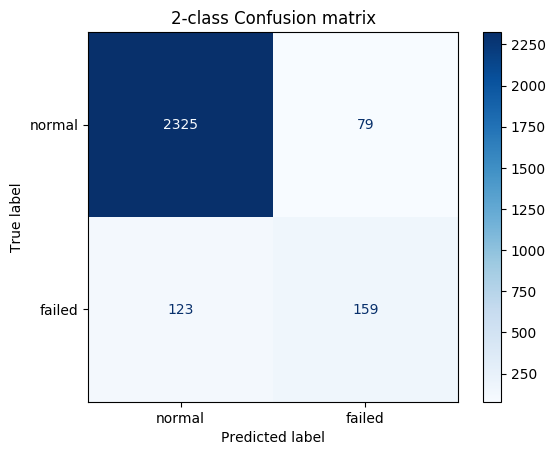

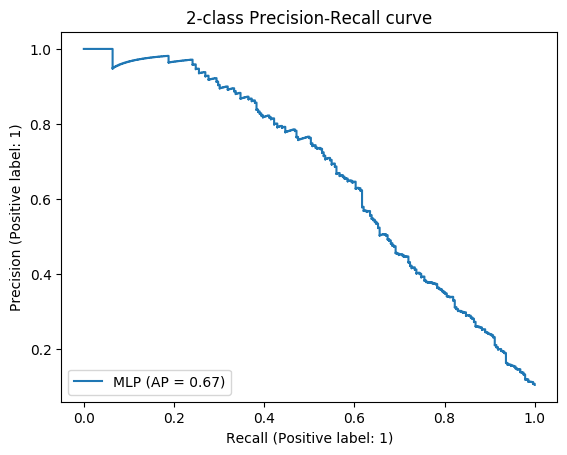

In [18]:
# == Experimental: Use low frequency real+imag FFT features with a classifier to try classify the typical failure kink that happens at the beginning ==
N_data = len(X) # Use subset of data if necessary
seqlen = 600 # limit sequence length if necessary (MAX 600)
skip = 1 # Every data point is probably not necessary, we can skip every nth

# Get fft of data
X_fft_comp = np.fft.rfft(X[:N_data, 0:seqlen:skip], norm="forward")

# Make just get the first n_feats frequencies and concatenate the real(amplitudes) + imag(phases) parts.
n_feats = 20
X_fft = np.concatenate((X_fft_comp.real[:, :n_feats], X_fft_comp.imag[:, :n_feats]), axis=1)

# Split into training and test data
X_train, X_test, y_train, y_test = \
       sklearn.model_selection.train_test_split(X_fft[:N_data, 0:seqlen:skip], Y[:N_data], random_state=1337, train_size=0.9)

# Train and evaluate
model_name = "MLP"
clf_dict = {"MLP" : MLPClassifier(alpha=1e-5, hidden_layer_sizes=(20, 20), solver="adam", learning_rate_init=0.003),
            "AB" : AdaBoostClassifier()}
clf = make_pipeline(StandardScaler(), clf_dict[model_name]) 
clf.fit(X_train, y_train)

evaluate_classif(clf, X_train, y_train, X_test, y_test, model_name)

In [ ]:
# == Experimental: Test simple handcrafted algorithm for the typical failure kink detection. (doesn't work) ==

# Classifier parameters
window_width = 15

# Params: t1 = 0.138, t2 = 0.39, t3 = 0.97
def manual_classifier(seq, params):
    """
        Define several relative hystereses thresholds and go over the whole sequence one by one to see if we can detect the up-down-up characteristic of the kink
        Return true if the sequence features a pump failure
    """
    
    t1, t2, t3 = params
    
    # Filter high frequency noise from sequence
    cumsum_vec = np.cumsum(np.insert(seq, 0, 0)) 
    seq_filt = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    
    pivot = 0
    cur_max_val = 0
    cur_min_val = 10
    state = 0
    for i in range(np.minimum(len(seq_filt), 100)):
        val = seq_filt[i]
        
        if val > cur_max_val:
            cur_max_val = val
        if val < cur_min_val:
            cur_min_val = val
                
        if state == 0:
            # In this state the sequence is rising from the start
            if val < cur_max_val - t1:
                cur_max_val = 0
                cur_min_val = 10
                state = 1
        if state == 1:
            # In this state we have already had our failure and pressure is dropping
            if val > cur_min_val + t2:
                cur_max_val = 0
                cur_min_val = 10
                state = 2
        if state == 2:
            # In this state the pressure is rising after the drop and we will just check that it rises above a certain threshold
            if val > cur_min_val + t3:
                return True
        
    return False
        
import optuna
import random

def objective(X, Y, classif, trial):
    t1 = trial.suggest_float("t1", 0.1, 1)
    t2 = trial.suggest_float("t2", 0.1, 1)
    t3 = trial.suggest_float("t3", 0.1, 1)
    params = t1, t2, t3
        
    batchsize=300
    indeces_subset = random.sample(range(0, len(X)), batchsize)
    X_subset = X[indeces_subset]
    Y_subset = Y[indeces_subset]
    
    Y_ = np.array([classif(x, params) for x in X_subset])
    
    score = (Y_subset == Y_).sum()
    
    return score
    
timeout = 20.0
print(f"Running optimization for {timeout} seconds...")
study = optuna.create_study(direction="maximize")
study.optimize(lambda t : objective(X, Y, manual_classifier, t), timeout=timeout)

print(f"Best value is : {study.best_value}, with param vec: {study.best_params}")

params = [study.best_params['t1'],
          study.best_params['t2'],
          study.best_params['t3']]

# == Evaluate

# N data points
N = 1000

# Evaluate the classifier
Y_ = np.array([manual_classifier(x, params) for x in X[:N]])

# True positives
tp = (Y_ & Y[:N]).sum()

# True negatives
tn = (~Y_ & ~Y[:N]).sum()

# False positives
fp = (Y_ & ~Y[:N]).sum()

# False negatives
fn = (~Y_ & Y[:N]).sum()

prec = tp / (tp + fp)
rec = tp / (tp + fn)
F = (2 * prec * rec) / (prec + rec)

print(f"True positives: {tp}, True negatives: {tn}, False positives: {fp}, False negatives: {fn}, Precision: {prec}, Recall: {rec}, F-score: {F}")

[I 2022-08-21 20:42:01,741] A new study created in memory with name: no-name-5d00fc87-ca2c-462c-bfb2-35daa5fac2ac
[I 2022-08-21 20:42:01,809] Trial 0 finished with value: 266.0 and parameters: {'t1': 0.7606827567591466, 't2': 0.7722383154158768, 't3': 0.9871420054374882}. Best is trial 0 with value: 266.0.
[I 2022-08-21 20:42:01,871] Trial 1 finished with value: 263.0 and parameters: {'t1': 0.4622199759027208, 't2': 0.34879663518423565, 't3': 0.891772670418719}. Best is trial 0 with value: 266.0.
[I 2022-08-21 20:42:01,934] Trial 2 finished with value: 267.0 and parameters: {'t1': 0.5784171430860822, 't2': 0.8062670010412157, 't3': 0.823742798546908}. Best is trial 2 with value: 267.0.


Running optimization for 20.0 seconds...


[I 2022-08-21 20:42:01,998] Trial 3 finished with value: 268.0 and parameters: {'t1': 0.596004185708035, 't2': 0.7332520640540531, 't3': 0.749218150592548}. Best is trial 3 with value: 268.0.
[I 2022-08-21 20:42:02,060] Trial 4 finished with value: 271.0 and parameters: {'t1': 0.712777766544899, 't2': 0.39506676867872526, 't3': 0.9386790751062756}. Best is trial 4 with value: 271.0.
[I 2022-08-21 20:42:02,122] Trial 5 finished with value: 272.0 and parameters: {'t1': 0.8345226887613246, 't2': 0.1989316778796103, 't3': 0.4479220657572194}. Best is trial 5 with value: 272.0.
[I 2022-08-21 20:42:02,185] Trial 6 finished with value: 264.0 and parameters: {'t1': 0.9891096950841988, 't2': 0.1991362643532179, 't3': 0.6611940652163669}. Best is trial 5 with value: 272.0.
[I 2022-08-21 20:42:02,247] Trial 7 finished with value: 255.0 and parameters: {'t1': 0.5281618506319522, 't2': 0.8323360246260711, 't3': 0.6296985435184359}. Best is trial 5 with value: 272.0.
[I 2022-08-21 20:42:02,308] Tria